In [7]:
from pprint import pprint
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg
import math
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, '/home/cj/Github/CFD_Class/python_files/')
from BCs_Taylor_Green import BCs
from Sparse_A import Build_Sparse_A_Neumann
from G_Terms import Build_G1, Build_G2
from Error_Analysis import error_analysis
from Plotting import Pressure_Plotting, u_Plotting, v_Plotting, Vorticity_Plotting
#from Plotting import u_Plotting
from Pressure_Terms import Pressure_Terms
from Staggered_Grid_Generation import Generate_Grid
from Taylor_Green_Analytical_Solution import Analytical_Solution
from Vorticity import Vorticity
%matplotlib inline

In [8]:
def Euler(u, v, Nx, Ny, dx, dy, nu, nt):
    for t in range(0,nt):
        print type(range(0,nt))
        un = np.empty_like(u)
        vn = np.empty_like(v)
        #copy info from last loop, needed for current loop into variable_n
        un = u.copy()
        vn = v.copy()
        #Pn = p.copy()
        T = 0 + t*dt
        
        un, vn = BCs(un, vn)
        G1 = Build_G1(un, vn, dx, dy, nu)
        G2 = Build_G2(un, vn, dx, dy, nu)
        u1 = un + (dt*G1)
        v1 = vn + (dt*G2)
        u1, v1 = BCs(u1, v1)
        #Solve for Pressure Field
        b1 = np.zeros((Ny+2,Nx+2), dtype=float)
        b1[1:-1,1:-1] = ((u1[1:-1,2:-1] - u1[1:-1,1:-2])/dx +\
            (v1[2:-1,1:-1] - v1[1:-2,1:-1])/dy)*(dx**2)
        b1 = np.reshape(b1[1:-1,1:-1], Ny*Nx)
        #A1 = Poisson_Solver_Neumann(Nx, Ny)
        A1 = Build_Sparse_A_Neumann(Nx, Ny)
        b1 = b1[:]*(1.0/dt)
        #temp1 = np.linalg.solve(A1,b1)
        temp1 = scipy.sparse.linalg.spsolve(A1,b1)
        
        p_star = np.reshape(temp1, (Ny,Nx))
        p_star = p_star[:,:] - p_star[Ny/2,Nx/2]

        F1_Pstar, F2_Pstar = Pressure_Terms(p_star, dx, dy)

        #calc predictor velocities
        u_star = u1.copy()
        v_star = v1.copy()

        u_star[1:-1,2:-2] = u1[1:-1,2:-2] - (dt*F1_Pstar)
        v_star[2:-2,1:-1] = v1[2:-2,1:-1] - (dt*F2_Pstar)
        
        if t % 100 == 0:
            print 'time step is %1.0f' % t
        if t == 1999:
            print "Hello"


In [24]:
#use this to check CFL and viscous condition
nu = 1  #viscosity of the fluid
t_s, t_e = 0, 2.0   #start and end times
dt = .001
nt = int((t_e-t_s)/dt)
#[.01, .005, .001]

Lx = 2.0*math.pi
Ly = 2.0*math.pi
xs, ys = 0.0, 0.0
Ny, Nx = 256, 256

#Call mesh
x, y, xp, yp, p_exact, xu, yu, u_exact, xv, yv, v_exact,\
        dx, dy = Generate_Grid(Lx, Ly, Nx, Ny, xs, ys)
    
#Temp variables for CFL
p_temp = np.zeros((Ny,Nx), dtype=float)
u_temp = np.zeros((Ny+2,Nx+3), dtype=float)
v_temp = np.zeros((Ny+3,Nx+2), dtype=float)
T_0 = 0

#Setting ICs
for i in range(0,Ny+2):
    for j in range(0,Nx+3):
        u_temp[i,j] = -np.exp(0)*np.cos(xu[j])*np.sin(yu[i])

    
for i in range(0,Ny+3):
    for j in range(0,Nx+2):
        v_temp[i,j] = np.exp(0)*np.sin(xv[j])*np.cos(yv[i])

        
for i in range(0,Ny):
    for j in range(0,Nx):
        p_temp[i,j] = -0.25*np.exp(0)*(np.cos(2.0*xp[j]) + np.cos(2.0*yp[i]))

#CFL Condition
mag_u = np.linalg.norm(u_temp, 1)
mag_v = np.linalg.norm(v_temp, 1)
int1 = mag_u/dx
int2 = mag_v/dy
if int1 > int2:
    CFL_dt = 0.3/int1
    print CFL_dt
else:
    CFL_dt = 0.3/int2
    print CFL_dt
    
#Viscous Condition
int3 = (nu * CFL_dt)/dx**2
int4 = (nu * CFL_dt)/dy**2
if int3 <= 0.62:
    print 'x condition met'
if int4 <= 0.62:
    print 'y condition met'

4.43685312823e-05
x condition met
y condition met


In [25]:
#Use this cell for running a single simulation
error_u = np.zeros((1,2), dtype=float)
error_v = np.zeros((1,2), dtype=float)
error_p = np.zeros((1,2), dtype=float)
error_vort = np.zeros((1,2), dtype=float)

#Call mesh
x, y, xp, yp, p_exact, xu, yu, u_exact, xv, yv, v_exact,\
    dx, dy = Generate_Grid(Lx, Ly, Nx, Ny, xs, ys)
#Call my IC's
uIC, vIC, pIC = Analytical_Solution(u_exact, v_exact, p_exact, xu, yu,\
    xv, yv, xp, yp, 0.0, Nx, Ny)
#Call end values
u_end, v_end, p_end = Analytical_Solution(u_exact, v_exact, p_exact,\
    xu, yu, xv, yv, xp, yp, 2.0, Nx, Ny)
vort_end = Vorticity(u_end[:,1:], v_end[1:,:], dx, dy)
#Call Euler
#u, v, p = Euler(uIC, vIC, Nx, Ny, dx, dy, nu, nt)

u = uIC.copy()
v = vIC.copy()
p = pIC.copy()

for t in range(0,nt):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    #copy info from last loop, needed for current loop into variable_n
    un = u.copy()
    vn = v.copy()
    #Pn = p.copy()
    T = 0 + t*dt

    un, vn = BCs(un, vn)
    G1 = Build_G1(un, vn, dx, dy, nu)
    G2 = Build_G2(un, vn, dx, dy, nu)
    u1 = un + (dt*G1)
    v1 = vn + (dt*G2)
    u1, v1 = BCs(u1, v1)
    #Solve for Pressure Field
    b1 = np.zeros((Ny+2,Nx+2), dtype=float)
    b1[1:-1,1:-1] = ((u1[1:-1,2:-1] - u1[1:-1,1:-2])/dx +\
        (v1[2:-1,1:-1] - v1[1:-2,1:-1])/dy)*(dx**2)
    b1 = np.reshape(b1[1:-1,1:-1], Ny*Nx)
    #A1 = Poisson_Solver_Neumann(Nx, Ny)
    A1 = Build_Sparse_A_Neumann(Nx, Ny)
    b1 = b1[:]*(1.0/dt)
    #temp1 = np.linalg.solve(A1,b1)
    temp1 = scipy.sparse.linalg.spsolve(A1,b1)

    p_star = np.reshape(temp1, (Ny,Nx))
    p_star = p_star[:,:] - p_star[Ny/2,Nx/2]

    F1_Pstar, F2_Pstar = Pressure_Terms(p_star, dx, dy)

    #calc predictor velocities
    u_star = u1.copy()
    v_star = v1.copy()

    u_star[1:-1,2:-2] = u1[1:-1,2:-2] - (dt*F1_Pstar)
    v_star[2:-2,1:-1] = v1[2:-2,1:-1] - (dt*F2_Pstar)
    
    if t % 100 == 0:
        print 'time step is %1.0f' % t

time step is 0
time step is 100
time step is 200
time step is 300
time step is 400
time step is 500
time step is 600
time step is 700
time step is 800
time step is 900
time step is 1000
time step is 1100
time step is 1200
time step is 1300
time step is 1400
time step is 1500
time step is 1600
time step is 1700
time step is 1800
time step is 1900


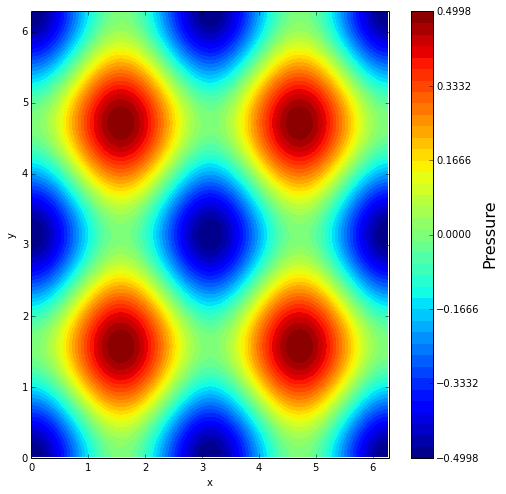

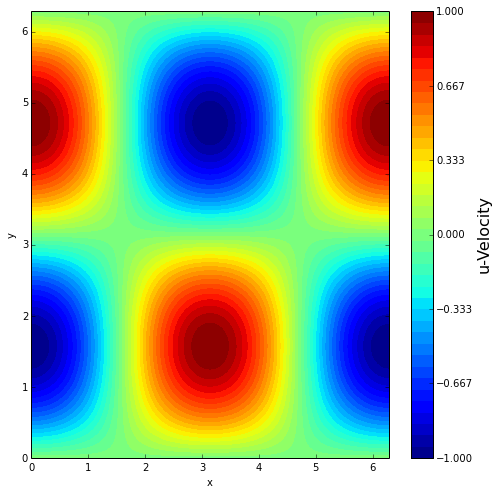

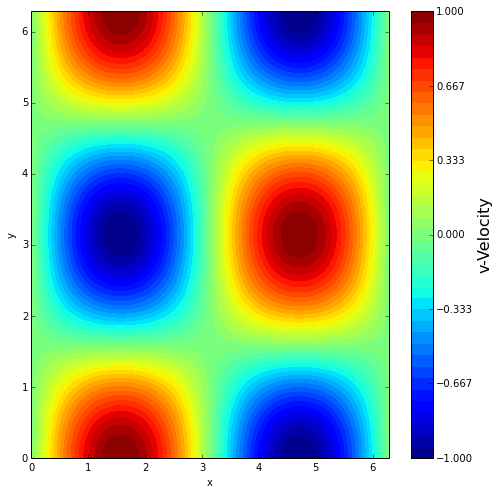

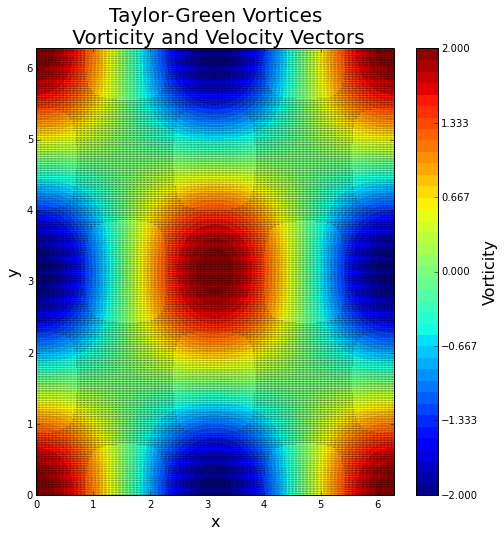

In [26]:
#Calc Vorticity
vort = Vorticity(u[:,1:], v[1:,:], dx, dy)
#plotting
Pressure_Plotting(p, xp, yp, Nx, nt)
u_Plotting(u, xu, yu, Nx, nt)
v_Plotting(v, xv, yv, Nx, nt)
Vorticity_Plotting(u, v, vort, xv, yv, Nx, nt)
#error calc
error_u[0,0], error_u[0,1] = error_analysis(u, u_end)
error_v[0,0], error_v[0,1] = error_analysis(v, v_end)
error_p[0,0], error_p[0,1] = error_analysis(p, p_end)
error_vort[0,0], error_vort[0,1] = error_analysis(vort, vort_end)
np.savez('error_%1.0f_xpts_%1.0f_tstep_Euler' %(Nx, nt), u=error_u, v=error_v, p=error_p, vort=error_vort)

In [27]:
#Loading spatial convergence data
temp32 = np.load('Euler_Saved_Files/error_32_xpts_2000_tstep_Euler.npz')
temp64 = np.load('Euler_Saved_Files/error_64_xpts_2000_tstep_Euler.npz')
temp128 = np.load('Euler_Saved_Files/error_128_xpts_2000_tstep_Euler.npz')
temp256 = np.load('Euler_Saved_Files/error_256_xpts_2000_tstep_Euler.npz')

p_32_error_temp = temp32['p']
u_32_error_temp = temp32['u']
v_32_error_temp = temp32['v']
vort_32_error_temp = temp32['vort']

p_64_error_temp = temp64['p']
u_64_error_temp = temp64['u']
v_64_error_temp = temp64['v']
vort_64_error_temp = temp64['vort']

p_128_error_temp = temp128['p']
u_128_error_temp = temp128['u']
v_128_error_temp = temp128['v']
vort_128_error_temp = temp128['vort']

p_256_error_temp = temp256['p']
u_256_error_temp = temp256['u']
v_256_error_temp = temp256['v']
vort_256_error_temp = temp256['vort']

In [29]:
p32_1norm = p_32_error_temp[0,0]
p32_2norm = p_32_error_temp[0,1]
u32_1norm = u_32_error_temp[0,0]
u32_2norm = u_32_error_temp[0,1]
v32_1norm = v_32_error_temp[0,0]
v32_2norm = v_32_error_temp[0,1]
vort32_1norm = vort_32_error_temp[0,0]
vort32_2norm = vort_32_error_temp[0,1]

p64_1norm = p_64_error_temp[0,0]
p64_2norm = p_64_error_temp[0,1]
u64_1norm = u_64_error_temp[0,0]
u64_2norm = u_64_error_temp[0,1]
v64_1norm = v_64_error_temp[0,0]
v64_2norm = v_64_error_temp[0,1]
vort64_1norm = vort_64_error_temp[0,0]
vort64_2norm = vort_64_error_temp[0,1]

p128_1norm = p_128_error_temp[0,0]
p128_2norm = p_128_error_temp[0,1]
u128_1norm = u_128_error_temp[0,0]
u128_2norm = u_128_error_temp[0,1]
v128_1norm = v_128_error_temp[0,0]
v128_2norm = v_128_error_temp[0,1]
vort128_1norm = vort_128_error_temp[0,0]
vort128_2norm = vort_128_error_temp[0,1]

p256_1norm = p_256_error_temp[0,0]
p256_2norm = p_256_error_temp[0,1]
u256_1norm = u_256_error_temp[0,0]
u256_2norm = u_256_error_temp[0,1]
v256_1norm = v_256_error_temp[0,0]
v256_2norm = v_256_error_temp[0,1]
vort256_1norm = vort_256_error_temp[0,0]
vort256_2norm = vort_256_error_temp[0,1]

p1norm = [p32_1norm, p64_1norm, p128_1norm, p256_1norm]
p2norm = [p32_2norm, p64_2norm, p128_2norm, p256_2norm]
u1norm = [u32_1norm, u64_1norm, u128_1norm, u256_1norm]
u2norm = [u32_2norm, u64_2norm, u128_2norm, u256_2norm]
v1norm = [v32_1norm, v64_1norm, v128_1norm, v256_1norm]
v2norm = [v32_2norm, v64_2norm, v128_2norm, v256_2norm]
vort1norm = [vort32_1norm, vort64_1norm, vort128_1norm, vort256_1norm]
vort2norm = [vort32_2norm, vort64_2norm, vort128_2norm, vort256_2norm]

N_plot = [32*32, 64*64, 128*128, 256*256]

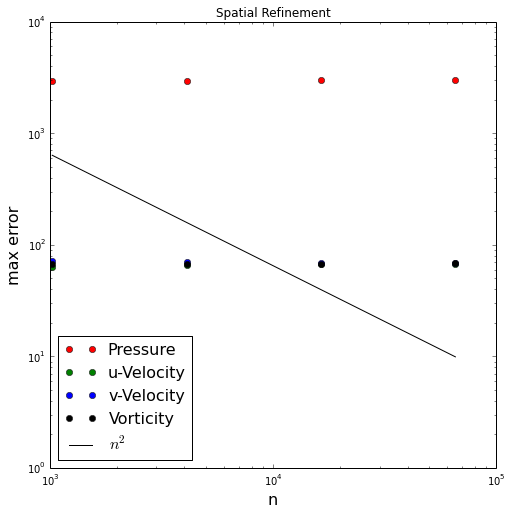

In [30]:
%matplotlib inline
conv_line = [u1norm[0] * 10, u1norm[0]/4 * 10, u1norm[0]/16 *10, u1norm[0]/(4*16) * 10]
figure = plt.figure(figsize=(8,8))
plt.ylabel('max error', fontsize=16)
plt.xlabel('n', fontsize=16)
plt.title('Spatial Refinement')
plt.loglog(N_plot, p1norm, 'ro', label='Pressure')
plt.loglog(N_plot, u1norm, 'go', label='u-Velocity')
plt.loglog(N_plot, v1norm, 'bo', label='v-Velocity')
plt.loglog(N_plot, vort1norm, 'ko', label='Vorticity')
plt.loglog(N_plot, conv_line, 'k-', label='$n^2$')
plt.legend(loc='best', prop={'size':16});